## ECoGデータの読み込みとダウンサンプリング

In [1]:
# /Users/murakamishoya/git/tt-lab/tt_github/ttlab-server/js13/js13-exp-1-1001-8-mf-150-mb350-ECoG-t1.npy
import os
import configparser
import numpy as np

conf = configparser.ConfigParser()
conf.read('./conf.ini')

original_sf = int(conf['ECOG']['original_sampling_freq'])   # 9600
re_sf = int(conf['BRAINBERT']['re_sampling_freq'])  # 2048

work_dir = os.path.dirname(os.getcwd())
js_dir = "js13"
npy_path = "js13-exp-1-1001-8-mf-150-mb350-ECoG-t1.npy"

input_path = f'{work_dir}/{js_dir}/{npy_path}'


In [2]:
import numpy as np
from scipy import signal

# Load the input data
input_data = np.load(input_path)

# def downsampling(input_data, original_sf=original_sf, re_sf=re_sf, lowpass_order=6):
#     # Calculate the downsample factor
#     downsample_factor = original_sf // re_sf

#     # Design a low-pass filter for anti-aliasing
#     nyquist_freq = 0.5 * original_sf
#     lowpass_cutoff = 0.5 * re_sf
#     lowpass_b, lowpass_a = signal.butter(lowpass_order, lowpass_cutoff / nyquist_freq, btype='low')

#     # Apply the low-pass filter and downsample
#     downsampled_data = signal.filtfilt(lowpass_b, lowpass_a, input_data, axis=0)[::downsample_factor]
#     return downsampled_data

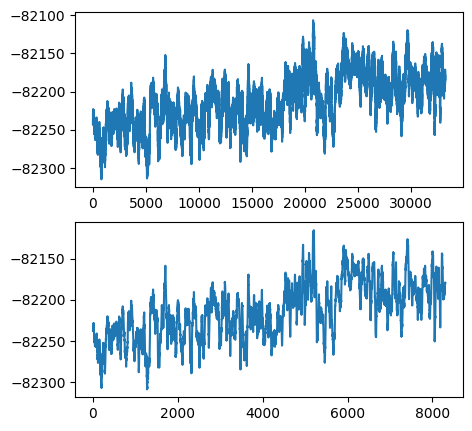

In [3]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, figsize=(5, 5))

axes[0].plot(input_data[:, 10])
axes[1].plot(downsampling(input_data[:, 10]))

In [4]:
type(downsampling(input_data[:, 10]))

numpy.ndarray

In [5]:
downsampling(input_data[:, 10]).shape

(8303,)

In [10]:
import os
import sys
module_path = f"{work_dir}/BrainBERT-master"
if module_path not in sys.path:
    sys.path.append(module_path)
import models

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch

In [7]:
# def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
#     f, t, Zxx = signal.stft(x, fs, **kwargs)
   
#     Zxx = Zxx[:clip_fs]
#     f = f[:clip_fs]

#     Zxx = np.abs(Zxx)
#     clip = 5 #To handle boundary effects
#     if normalizing=="zscore":
#         Zxx = Zxx[:,clip:-clip]
#         Zxx = stats.zscore(Zxx, axis=-1)
#         t = t[clip:-clip]
#     elif normalizing=="baselined":
#         Zxx = baseline(Zxx[:,clip:-clip])
#         t = t[clip:-clip]
#     elif normalizing=="db":
#         Zxx = np.log2(Zxx[:,clip:-clip])
#         t = t[clip:-clip]

#     if np.isnan(Zxx).any():
#         import pdb; pdb.set_trace()

#     return f, t, Zxx

# # downsamplingを追加
# # chを選択
# def plot_stft(path, ch):
#     wav = np.load(path)[:, ch]
#     wav = downsampling(wav)
#     f,t,linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
#     plt.figure(figsize=(15,3))
#     f[-1]=200
#     g1 = plt.pcolormesh(t,f,linear, shading="gouraud", vmin=-3, vmax=5)

#     cbar = plt.colorbar(g1)
#     tick_font_size = 15
#     cbar.ax.tick_params(labelsize=tick_font_size)
#     cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
#     plt.xticks(fontsize=20)
#     plt.ylabel("")
#     plt.yticks(fontsize=20)
#     plt.xlabel("Time (s)", fontsize=20)
#     plt.ylabel("Frequency (Hz)", fontsize=20)

In [18]:
# ダウンサンプリング（input_dataだけ指定すれば良い）
def downsampling(input_data, original_sf=original_sf, re_sf=re_sf, lowpass_order=6):
    # Calculate the downsample factor
    downsample_factor = original_sf // re_sf

    # Design a low-pass filter for anti-aliasing
    nyquist_freq = 0.5 * original_sf
    lowpass_cutoff = 0.5 * re_sf
    lowpass_b, lowpass_a = signal.butter(lowpass_order, lowpass_cutoff / nyquist_freq, btype='low')

    # Apply the low-pass filter and downsample
    downsampled_data = signal.filtfilt(lowpass_b, lowpass_a, input_data, axis=0)[::downsample_factor]
    return downsampled_data

def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)
   
    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5 #To handle boundary effects
    if normalizing=="zscore":
        Zxx = Zxx[:,clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing=="baselined":
        Zxx = baseline(Zxx[:,clip:-clip])
        t = t[clip:-clip]
    elif normalizing=="db":
        Zxx = np.log2(Zxx[:,clip:-clip])
        t = t[clip:-clip]

    if np.isnan(Zxx).any():
        import pdb; pdb.set_trace()

    return f, t, Zxx

# downsamplingを追加
# chを選択
def plot_stft(ecog, ch):
    f,t,linear = get_stft(ecog[:, ch], 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
    plt.figure(figsize=(15,3))
    f[-1]=200
    g1 = plt.pcolormesh(t,f,linear, shading="gouraud", vmin=-3, vmax=5)

    cbar = plt.colorbar(g1)
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
    plt.xticks(fontsize=20)
    plt.ylabel("")
    plt.yticks(fontsize=20)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Frequency (Hz)", fontsize=20)

    plt.show()

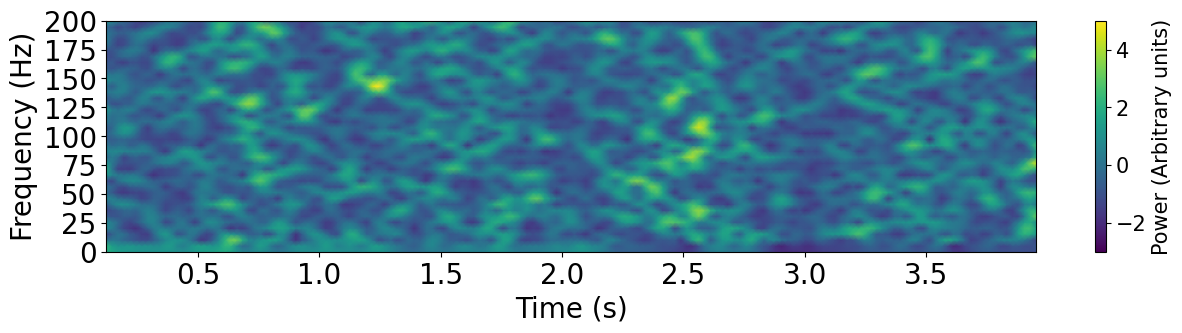

In [19]:
# plot_stft(input_path, 10)
input_data = np.load(input_path)
downsampled_data = downsampling(input_data)
plot_stft(downsampled_data, 10)

## モデルの読み込み

In [11]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream

def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

In [14]:
! pip install omegaconf

In [17]:
from omegaconf import OmegaConf
ckpt_path = f"{work_dir}/BrainBERT-master/pretrained_weights/stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
model = build_model(cfg)
model.to('cuda')
init_state = torch.load(ckpt_path)
load_model_weights(model, init_state['model'], False)

In [21]:
input_data = np.load(input_path)
downsampled_data = downsampling(input_data)[:, 10]

f,t,linear = get_stft(downsampled_data, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1,2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda')
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)

In [22]:
inputs.shape, out.shape

(torch.Size([1, 158, 40]), torch.Size([1, 158, 768]))